In [1]:
# prepare data for snntorch
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
from concurrent.futures import ProcessPoolExecutor
from sklearn.utils import shuffle
import random
from torch.utils.data import DataLoader

import snntorch as snn
import torch
import re

sub_dirs = ['1_4', '2_4', '3_4', '4_4', '5_4', '7_8']
CORE_COUNT : int = int(cpu_count())
num_features = 1  # onset_strength and BPM # pnly onset_strength # surrogate + onset
DIRTY = True
batch_size = 32
onset_padding = 20
FILES_TO_LOAD = 100
SR = int(16000)

print(f"Number of cores used: {CORE_COUNT}")

def get_length(file_path):
    y, sr = librosa.load(file_path, sr=SR)
    mfccs = librosa.feature.melspectrogram(y=y, sr=sr)
    return mfccs.shape[1]

def determine_fixed_length(directory):
    file_paths = []

    for subdir in sub_dirs:
        files_to_load = os.listdir(os.path.join(directory, subdir))[:FILES_TO_LOAD]
        for file in tqdm(files_to_load):
            file_path = os.path.join(directory, subdir, file)
            file_paths.append(file_path)

    # Utilize multiprocessing for faster computation
    with ProcessPoolExecutor() as executor:
        lengths = list(executor.map(get_length, file_paths))
    
    return min(lengths)

def parallel_data_loader(directories):
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(parallel_load_and_preprocess, directories), total=len(directories)))
    return results

def load_and_preprocess_data_subdir(args):
    directory, subdir = args
    data = []
    labels = []
    val_bpm = []
    time_signatures = []
    
    # Only load up to 20 files per subdirectory
    files_to_load = os.listdir(os.path.join(directory, subdir))[:FILES_TO_LOAD]

    
    for file in files_to_load:
        file_path = os.path.join(directory, subdir, file)
        processed_data, bpm_librosa = preprocess_audio(file_path)
        data.append(processed_data)
        instrument, bpm, _, _ = extract_bpm_and_instrument(file_path)
        time_signature = sub_dirs.index(subdir)
        label = int(bpm)
        labels.append(label)
        val_bpm.append(bpm_librosa)
        time_signatures.append(time_signature)
    
    return data, labels, val_bpm, time_signatures


def extract_bpm_and_instrument(file_path):
    # Using \d+ to match one or more digits and [\d.]+ to match a float or integer pattern for noise.
    match = re.search(r"instrument_(\d+)_bpm_(\d+)_rotation_\d+_duration_(\d+)_noise_([\d.]+)", file_path)
    if match:
        instrument = match.group(1)
        bpm = match.group(2)
        duration = match.group(3)
        noise = match.group(4)
        return instrument, bpm, duration, noise
    return None, None, None, None

def parallel_load_and_preprocess(directory):
    # Create a pool of processes
    pool = Pool(CORE_COUNT)

    # Create a list of tasks
    tasks = [(directory, time_sig) for time_sig in sub_dirs]

    # Use imap_unordered to distribute the work among the processes
    results = list(tqdm(pool.imap_unordered(load_and_preprocess_data_subdir, tasks), total=len(tasks), mininterval=0.01))

    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()

    # Combine results
    combined_data = []
    combined_labels = []
    combined_bpm = []
    combined_time_signatures = []
    
    for data, labels, val_bpm, tim_sig in results:
        combined_data.extend(data)
        combined_labels.extend(labels)
        combined_bpm.extend(val_bpm)
        combined_time_signatures.extend(tim_sig)
        
    
    return combined_data, combined_labels, combined_bpm, combined_time_signatures


def adjust_fixed_length(features, timesteps, time_axis=-1):
    """
    Adjust the length of a data array along the specified time axis.

    :param features: The input data array to adjust.
    :param timesteps: The desired length of the time axis.
    :param time_axis: The axis to adjust. Defaults to the last axis.
    :return: The adjusted array.
    """
    if time_axis < 0:
        time_axis = features.ndim + time_axis
    
    # Check if the current length of the time axis matches the desired length
    if features.shape[time_axis] == timesteps:
        return features
    
    # Indices to slice; a full slice for all dimensions
    slicer = [slice(None)] * features.ndim

    # If the current length is greater than the desired length, crop it
    if features.shape[time_axis] > timesteps:
        slicer[time_axis] = slice(0, timesteps)
        return features[tuple(slicer)]
    
    # If the current length is less than the desired length, pad it
    else:
        padding_length = timesteps - features.shape[time_axis]
        pad_widths = [(0, 0) if i != time_axis else (0, padding_length) for i in range(features.ndim)]
        return np.pad(features, pad_widths, mode='constant')


def preprocess_audio(file_path):
    # y, sr = librosa.load(file_path, sr=22050)  # setting sr ensures all files are resampled to this rate
    y, sr = librosa.load(file_path, sr=SR)  # setting sr ensures all files are resampled to this rate
    # instrument, bpm = extract_bpm_and_instrument(file_path)

    # Extracting onset strength
    # onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
    # onset_strength_adjusted = adjust_fixed_length(onset_strength, fixed_timesteps)
    # onset_strength_adjusted = onset_strength_adjusted[onset_padding:] # onset strength got weird spikes at the beginning
    # onset_strength_normalized = (onset_strength_adjusted - np.min(onset_strength_adjusted)) / (np.max(onset_strength_adjusted) - np.min(onset_strength_adjusted))
    
    
    # Extracting Mel spectrogram
     # Extracting Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        # Extracting BPM (Tempo)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    
    # Get the Mel frequency values
    mel_freqs = librosa.core.mel_frequencies(n_mels=mel_spectrogram.shape[0], fmin=0, fmax=sr/2)
    
    # Identify indices corresponding to 20Hz and 4kHz
    idx_start = np.where(mel_freqs >= 20)[0][0]
    idx_end = np.where(mel_freqs <= 4000)[0][-1]
    
    # Slice the Mel spectrogram to retain only the desired bands
    mel_spectrogram = mel_spectrogram[idx_start:idx_end+1, :]
    
    # Adjusting Mel spectrogram length if necessary (similar to onset_strength_adjusted)
    mel_spectrogram_adjusted =  adjust_fixed_length(mel_spectrogram, fixed_timesteps, 1) # adjust as needed
    mel_spectrogram_normalized = (mel_spectrogram_adjusted - np.min(mel_spectrogram_adjusted)) / (np.max(mel_spectrogram_adjusted) - np.min(mel_spectrogram_adjusted))
    
    
    
    # Extracting BPM (Tempo)
    # tempo, _ = librosa.beat.beat_track(onset_envelope=onset_strength, sr=sr)
    
    # # Normalizing tempo
    # max_tempo = 200.0  # Assume a reasonable max tempo (you may need to adjust this)
    # tempo_normalized = tempo / max_tempo
    
    # # Making it a 2D array to match the dimensions of onset_strength_normalized
    # tempo_feature = np.full((1, onset_strength_normalized.shape[0]), tempo_normalized)
    
    # # Check shapes
    # # print("Onset Strength Shape:", onset_strength_normalized.shape)
    # # print("Tempo Shape:", tempo_feature.shape)
    
    # # Combine onset strength and BPM
    # onset_strength_normalized = onset_strength_normalized.reshape(1, -1)  # reshaping to make it a 2D array
    
    # combined_features = np.vstack([onset_strength_normalized, tempo_feature])
    # num_features +=1
    combined_features = np.vstack(mel_spectrogram_normalized), tempo

    return combined_features


def count_files(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])


# checking shapes
print("Checking shapes...")

training_data_path = 'training_data_dirty_bpm' if DIRTY else 'training_data_clean'
validation_data_path = 'validation_data_dirty_bpm' if DIRTY else 'validation_data_clean'

fixed_timesteps = determine_fixed_length(training_data_path)
print(fixed_timesteps)
# fixed_timesteps2 = determine_fixed_length(validation_data_path)
# print(fixed_timesteps2)
# fixed_timesteps = max(fixed_timesteps, fixed_timesteps2)
# 1. Load and preprocess data
print("Loading and preprocessing training data...")
directories = [training_data_path, validation_data_path]
training_data_results, validation_data_results = parallel_data_loader(directories)

training_data, training_labels, training_bpms, training_timesigs = training_data_results
validation_data, validation_labels, validation_bpms, validation_timesigs = validation_data_results
print("\nDone with preprocessing!")

# all_data = training_data + validation_data
# fixed_timesteps = min([data.shape[0] for data in all_data])
# print(f"Fixed timesteps: {fixed_timesteps}")
# print(f"shape of training data: {training_data[0].shape}")
# print(f"shape of training data: {training_data[0]}")


# mel_frequencies = librosa.mel_frequencies(n_mels=all_data[0].shape[0], fmax=SR/2)
# index_4kHz = np.argmin(np.abs(mel_frequencies - 3000))
# for i in range(0, 4):

#     sample_index = np.random.randint(0, len(training_data))
#     data = training_data[sample_index][:index_4kHz, :]  # Slice the data
#     print(f"shape of data: {data.shape}")
#     # librosa.display.specshow(librosa.power_to_db(data, ref=np.max), y_axis='mel', x_axis='time')
#     plt.imshow(librosa.power_to_db(data, ref=np.max), origin='lower', aspect='auto')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title(f'Mel spectrogram {training_labels[sample_index]}')
#     plt.show()
#     # librosa.display.specshow(librosa.power_to_db(training_data[sample_index], ref=np.max), y_axis='mel', x_axis='time')
#     plt.imshow(librosa.power_to_db(training_data[sample_index], ref=np.max), origin='lower', aspect='auto')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title(f'Mel spectrogram {training_labels[sample_index]}')
#     plt.show()
    
    
    
    # plt.plot(training_data[i])
    # plt.title(f"Random Sample from Normalized Data {training_labels[i]}")
    # plt.show()
    
    




Number of cores used: 16
Checking shapes...


100%|██████████| 100/100 [00:00<00:00, 400219.85it/s]


85
Loading and preprocessing training data...


  0%|          | 0/2 [00:00<?, ?it/s]






100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Done with preprocessing!


In [23]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

class CustomAudioDataset(Dataset):
    def __init__(self, data, labels, bpms, timesigs):
        self.data = data
        self.labels = labels
        self.bpms = bpms
        self.timesigs = timesigs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        bpm = self.bpms[idx]
        timesig = self.timesigs[idx]

        # Convert to PyTorch tensors
        sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)  # Add a channel dimension
        label = torch.tensor(label, dtype=torch.long)
        bpm = torch.tensor(bpm, dtype=torch.float32)
        timesig = torch.tensor(timesig, dtype=torch.long)

        return sample, label, bpm, timesig
    
    
class CustomAudioDatasetFast(Dataset):
    def __init__(self, data, bpms):
        self.data = data
        self.bpms = bpms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        bpm = self.bpms[idx]

        # Convert to PyTorch tensors
        sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)  # Add a channel dimension
        bpm = torch.tensor(bpm, dtype=torch.float32)

        return sample, bpm
    

batch_size = 32
    
print(f"preparing data loaders with batch size {batch_size}")
  
train_dataset = CustomAudioDataset(training_data, training_labels, training_bpms, training_timesigs)
test_dataset = CustomAudioDataset(validation_data, validation_labels, validation_bpms, validation_timesigs)

train_dataset_fast = CustomAudioDatasetFast(training_data, training_bpms)
test_dataset_fast = CustomAudioDatasetFast(validation_data, validation_bpms)

from tonic import DiskCachedDataset
cache_path="./cache/snn"
# create path if not exists
# if not os.path.exists(cache_path):
#     os.makedirs(cache_path)
cached_trainset = DiskCachedDataset(train_dataset_fast, cache_path=cache_path)
cached_dataloader = DataLoader(cached_trainset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

train_loader_fast = DataLoader(train_dataset_fast, batch_size=batch_size, shuffle=True, drop_last=True)

print("shape of training data: ", training_data[0].shape)

class BPMEstimator(nn.Module):
    def __init__(self, input_shape):
        super(BPMEstimator, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Compute the size after conv and pooling layers
        self.fc1_input_size = self.compute_flattened_size(input_shape)

        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # downsample by half
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # downsample by half
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def compute_flattened_size(self, input_shape):
        dummy_tensor = torch.ones(1, 1, *input_shape)  # Create a dummy batch with a batch size of 1 and 1 channel
        x = self.conv1(dummy_tensor)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        _, c, h, w = x.shape
        return c * h * w



input_shape = training_data[0].shape
model = BPMEstimator(input_shape)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def load_sample_batched():
    events, target, _, _ = next(iter(train_loader))
    
def load_sample_batched():
    for i, (events, target, _, _) in enumerate(iter(train_loader)):
        if i > 99:
            break
    
def load_sample_batched_cached():
    events, target = next(iter(cached_dataloader))
    
def load_sample_batched_cached():
    for i, (events, target) in enumerate(iter(train_loader_fast)):
        if i > 99:
            break

   


preparing data loaders with batch size 32
shape of training data:  (126, 85)


In [24]:
%timeit -o -r 10 load_sample_batched_cached() 


16.4 ms ± 592 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 16.4 ms ± 592 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

In [26]:
%timeit -o -r 100 load_sample_batched()

21.5 ms ± 818 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


<TimeitResult : 21.5 ms ± 818 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)>

In [ ]:
# SSN CNN linear regression

import torch
import snntorch as snn
from snntorch import surrogate
from torch.utils.data import DataLoader
import torch.nn.functional as F
from snntorch import functional as SF
import snntorch as snn
from snntorch import utils
import torch.nn as nn
from snntorch import spikegen
from torch.utils import bottleneck
import cProfile

def latency_encode_spikegen(data, num_steps=50):
    return spikegen.latency(data, time=num_steps)

def rate_encode_spikegen(data, num_steps=50):
    return spikegen.rate(data, num_steps=num_steps)

# Spiking Leaky Integrate-and-Fire (LIF) neuron
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

batch_size = 16
    
print(f"preparing data loaders with batch size {batch_size}")
  
train_dataset = CustomAudioDataset(training_data, training_labels, training_bpms, training_timesigs)
test_dataset = CustomAudioDataset(validation_data, validation_labels, validation_bpms, validation_timesigs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


def compute_flattened_size(net, input_shape):
    dummy_tensor = torch.ones(1, *input_shape)  # create a dummy input tensor
    output = net(dummy_tensor)
    return output.nelement()  # number of elements in the output tensor


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Fetch one batch of data
data_sample, _, _, _ = next(iter(train_loader))
b, c , H, W = data_sample.shape

print(f"Data shape: {data_sample.shape}")

# Define the convolutional part of the network
conv_layers = nn.Sequential(
    nn.Conv2d(c, 32, 3, padding=1), 
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    
    nn.Conv2d(32, 64, 3, padding=1),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
)

# Calculate the flattened size
flattened_size = compute_flattened_size(conv_layers, (c, H, W))

# Now define the fully connected part of the network using the computed flattened_size
fc_layers = nn.Sequential(
    nn.Flatten(),
    nn.Linear(flattened_size, 64),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Linear(64, 1)
)

# Finally, you can combine the two parts to define the final network
net = nn.Sequential(
    conv_layers,
    fc_layers
).to(device)



optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
loss_fn = nn.MSELoss()
num_epochs = 10
loss_hist = []
acc_hist = []

def your_training_function():
    torch.autograd.set_detect_anomaly(True)
    for epoch in range(num_epochs):
        for i, (data, targets, _, _) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            
            # Convert mel spectrograms into spike data
            data_spikes = rate_encode_spikegen(data)

            # Initialize tensor to accumulate output spikes
            time_dim = data_spikes.size(0)
            batch_output_spikes = torch.zeros(time_dim, batch_size, 1, device=device)

            net.train()

            # Unroll through the time dimension:
            for t in range(time_dim):
                out_spikes_t = net(data_spikes[t])
                batch_output_spikes[t, :, :] = out_spikes_t

            # Sum the spikes over the time window to obtain a continuous value
            output = torch.sum(batch_output_spikes, dim=0).squeeze()

            loss_val = loss_fn(output, targets.float())  # Assuming targets are the BPM values

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Logging
            loss_hist.append(loss_val.item())
            print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")




your_training_function()

In [3]:
# snn CNN classification
import torch
import snntorch as snn
from snntorch import surrogate
from torch.utils.data import DataLoader
import torch.nn.functional as F
from snntorch import functional as SF
import snntorch as snn
from snntorch import utils
import torch.nn as nn
from snntorch import spikegen
from torch.utils import bottleneck
import cProfile

def latency_encode_spikegen(data, num_steps=50):
    return spikegen.latency(data, time=num_steps)

def rate_encode_spikegen(data, num_steps=50):
    return spikegen.rate(data, num_steps=num_steps)

# Spiking Leaky Integrate-and-Fire (LIF) neuron
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

batch_size = 16
    
print(f"preparing data loaders with batch size {batch_size}")
  
train_dataset = CustomAudioDataset(training_data, training_labels, training_bpms, training_timesigs)
test_dataset = CustomAudioDataset(validation_data, validation_labels, validation_bpms, validation_timesigs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Find out the total number of unique classes from the training set
# Extract all unique labels from the ground truth labels in the train_loader
classes = torch.unique(torch.cat([bpms for _, bpms, _, _ in train_loader]))

# Determine the minimum and maximum labels
min_label = classes.min().item()
max_label = classes.max().item()

# Generate classes for every integer between the min and max labels
all_classes = list(range(0, max_label+1))

# Output the classes
num_classes = len(all_classes)
print(f"Total number of classes: {num_classes}")


def compute_flattened_size(net, input_shape):
    dummy_tensor = torch.ones(1, *input_shape)  # create a dummy input tensor
    output = net(dummy_tensor)
    return output.nelement()  # number of elements in the output tensor


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Fetch one batch of data
data_sample, _, _, _ = next(iter(train_loader))
b, c , H, W = data_sample.shape

print(f"Data shape: {data_sample.shape}")

# Define the convolutional part of the network
conv_layers = nn.Sequential(
    nn.Conv2d(c, 32, 3, padding=1), 
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    
    nn.Conv2d(32, 64, 3, padding=1),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
)

# Calculate the flattened size
flattened_size = compute_flattened_size(conv_layers, (c, H, W))

# Now define the fully connected part of the network using the computed flattened_size
fc_layers = nn.Sequential(
    nn.Flatten(),
    nn.Linear(flattened_size, 64),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Linear(64, num_classes)  # Set the number of output nodes to num_classes
)

# Finally, you can combine the two parts to define the final network
net = nn.Sequential(
    conv_layers,
    fc_layers
).to(device)



optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10
loss_hist = []
acc_hist = []

def your_training_function():
    torch.autograd.set_detect_anomaly(True)
    for epoch in range(num_epochs):
        for i, (data, targets, _, _) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)

            # Convert mel spectrograms into spike data
            data_spikes = rate_encode_spikegen(data)

            # Initialize tensor to accumulate output spikes
            time_dim = data_spikes.size(0)
            batch_output_spikes = torch.zeros(time_dim, batch_size, num_classes, device=device)

            net.train()

            # Unroll through the time dimension:
            for t in range(time_dim):
                out_spikes_t = net(data_spikes[t])
                batch_output_spikes[t, :, :] = out_spikes_t

            # Sum the spikes over the time window to obtain a continuous value
            output = torch.sum(batch_output_spikes, dim=0).squeeze()

            # CrossEntropyLoss expects raw logits, so no need for a softmax activation
            loss_val = loss_fn(output, targets.long())  # Make sure targets are of long type

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Calculate accuracy and log
            _, predicted = torch.max(output, 1)
            correct = (predicted == targets).sum().item()
            acc = correct / batch_size
            acc_hist.append(acc)

            # Logging
            loss_hist.append(loss_val.item())
            print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}, Accuracy: {acc:.2f}")





your_training_function()

preparing data loaders with batch size 16
Total number of classes: 141
Data shape: torch.Size([16, 1, 126, 85])


KeyboardInterrupt: 

In [4]:
import torch
import snntorch as snn
from snntorch import surrogate
from torch.utils.data import DataLoader
import torch.nn.functional as F
from snntorch import functional as SF
from snntorch import utils
import torch.nn as nn
from snntorch import spikegen

# Parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
batch_size = 128

# Data loading
print(f"preparing data loaders with batch size {batch_size}")
train_dataset = CustomAudioDataset(training_data, training_labels, training_bpms, training_timesigs)
test_dataset = CustomAudioDataset(validation_data, validation_labels, validation_bpms, validation_timesigs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Number of classes
classes = torch.unique(torch.cat([bpms for _, bpms, _, _ in train_loader]))
min_label = classes.min().item()
max_label = classes.max().item()
all_classes = list(range(0, max_label+1))
num_classes = len(all_classes)
print(f"Total number of classes: {num_classes}")

# Network setup
data_sample, _, _, _ = next(iter(train_loader))
b, c, H, W = data_sample.shape
print(f"Data shape: {data_sample.shape}")

conv_part = nn.Sequential(
    nn.Conv2d(c, 32, 3, padding=1),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)
)

dummy_data = torch.ones(1, c, H, W)
output = conv_part(dummy_data)
flattened_size = output.numel()

net = nn.Sequential(
    nn.Conv2d(c, 32, 3, padding=1),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Flatten(),
    nn.Linear(flattened_size, num_classes),  # Use the correct flattened size
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
).to(device)

# Training
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
num_epochs = 10
loss_hist = []
acc_hist = []

def forward_pass(net, data):
    spk_rec = []
    utils.reset(net)
    for step in range(data.size(0)):
        spk_out, _ = net(data[step])
        spk_rec.append(spk_out)
    return torch.stack(spk_rec)


def your_training_function():
    for epoch in range(num_epochs):
        for i, (data, targets, _, _) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            data_spikes = rate_encode_spikegen(data)
            net.train()
            spk_rec = forward_pass(net, data_spikes)
            loss_val = loss_fn(spk_rec, targets)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Calculate accuracy
            acc = SF.accuracy_rate(spk_rec, targets)
            acc_hist.append(acc)

            # Logging
            loss_hist.append(loss_val.item())
            print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}, Accuracy: {acc:.2f}")

your_training_function()


preparing data loaders with batch size 128
Total number of classes: 141
Data shape: torch.Size([128, 1, 126, 85])


: 

: 

preparing data loaders with batch size 128
Epoch 1/5, Training Loss: 7.4626 took 38.35 seconds
Epoch 2/5, Training Loss: 7.4949 took 37.67 seconds
Epoch 3/5, Training Loss: 7.4717 took 38.23 seconds
Epoch 4/5, Training Loss: 7.5074 took 38.89 seconds
Epoch 5/5, Training Loss: 7.4837 took 37.98 seconds


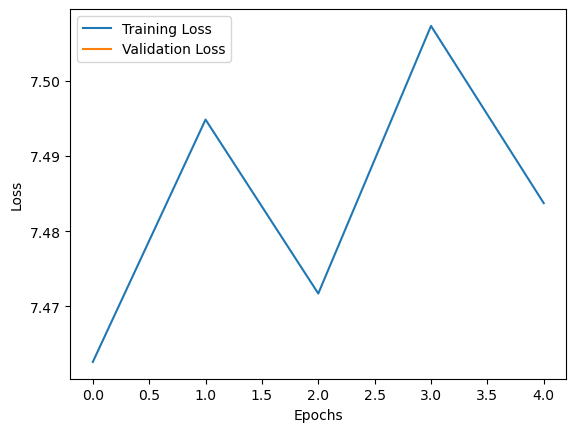

In [209]:
import matplotlib.pyplot as plt
import time

batch_size = 128
    
print(f"preparing data loaders with batch size {batch_size}")
  
train_dataset = CustomAudioDataset(training_data, training_labels, training_bpms, training_timesigs)
test_dataset = CustomAudioDataset(validation_data, validation_labels, validation_bpms, validation_timesigs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# ... [rest of your code]
epochs = 5
epoch_losses = []
validation_losses = []

start_time = time.time()

for epoch in range(epochs):
    epoch_loss = 0  # Resetting the epoch loss for each epoch
    
    model.train()
    for data, target, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(data).squeeze()  # Squeeze out the redundant dimension
        loss = criterion(outputs, target.float())
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {mean_epoch_loss:.4f} took {time.time() - start_time:.2f} seconds")
    start_time = time.time()

    
    # # Calculate validation loss
    # model.eval()
    # with torch.no_grad():
    #     val_loss = 0
    #     for data, target in test_loader:
    #         outputs = model(data).squeeze()
    #         loss = criterion(outputs, target.float())
    #         val_loss += loss.item()
    #     mean_val_loss = val_loss / len(test_loader)
    #     validation_losses.append(mean_val_loss)

    # print(f"Epoch {epoch+1}/{epochs}, Training Loss: {mean_epoch_loss:.4f} took {time.time() - start_time:.2f} seconds")

# Plot the loss over epochs
plt.plot(epoch_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [133]:
# Save the model
model_save_path = "BPMEstimator.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to BPMEstimator.pth


In [214]:
model_save_path = "BPMEstimator.pth"
model = BPMEstimator(input_shape)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

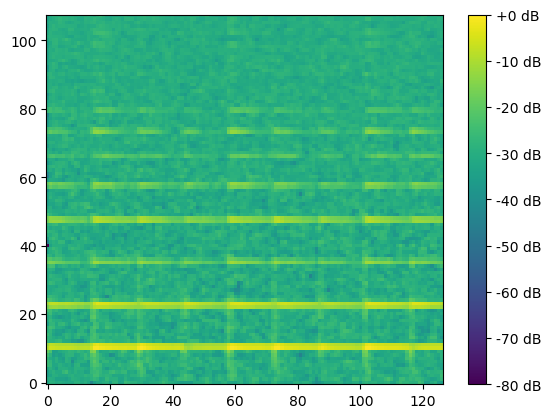

Librosa BPM Estimate: 100.45
0 

1 

2 

3 

4 

5 



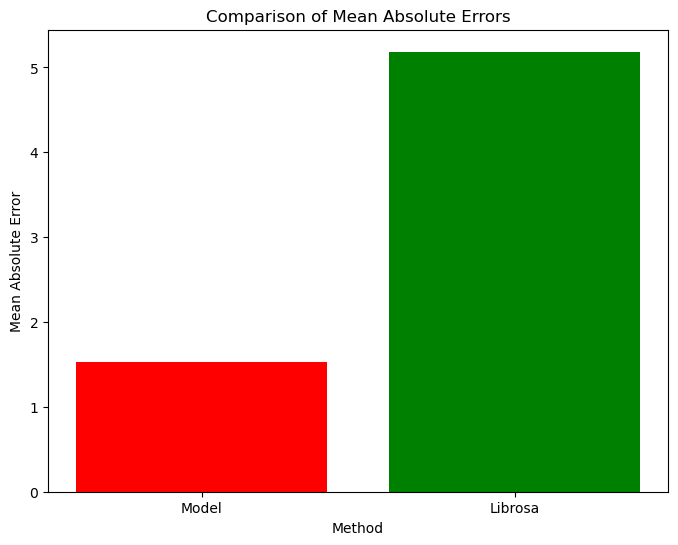

Model accuracy within ±5.0 BPM: 98.11%, Librosa accuracy within ±5.0 BPM: 87.46%


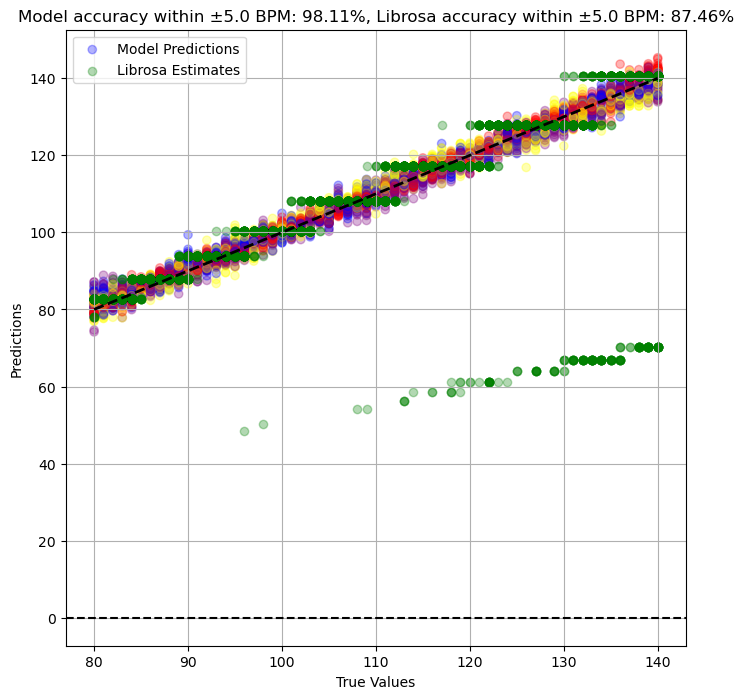

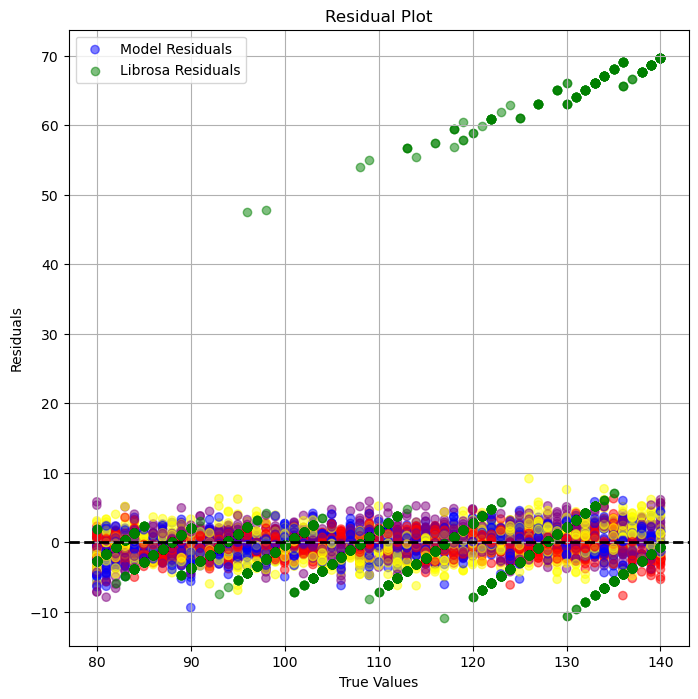

In [236]:
import matplotlib.pyplot as plt
import numpy as np
import librosa

data, targets, librosa_bpm, _ = next(iter(train_loader))

single_mel = data[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension

# librosa.display.specshow(librosa.power_to_db(data, ref=np.max), y_axis='mel', x_axis='time')
plt.imshow(librosa.power_to_db(single_mel, ref=np.max), origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.show()


print(f"Librosa BPM Estimate: {librosa_bpm[0]:.2f}")


batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


# Set model to evaluation mode
model.eval()

all_predictions = []
all_true_labels = []
librosa_bpm_estimates = []  # List to store Librosa's BPM estimates
all_timesigs = []  # List to store Librosa's BPM estimates


# No gradient is needed during evaluation/inference
cnt = 0
with torch.no_grad():
    for data, target, librosa_bpm, timesigs in test_loader:
        outputs = model(data).squeeze()
        predictions = outputs
        all_predictions.extend(predictions.cpu().numpy() - 1.15) 
        all_true_labels.extend(target.cpu().numpy())
        librosa_bpm_estimates.extend(librosa_bpm.cpu().numpy())
        all_timesigs.extend(timesigs.cpu().numpy())
        



# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
all_timesigs = np.array(all_timesigs)
librosa_bpm_estimates = np.array(librosa_bpm_estimates)


unique_time_sigs = set(all_timesigs)
for time_sig in unique_time_sigs:
    print(time_sig, "\n")

 #sub_dirs = ['1_4', '2_4', '3_4', '4_4', '5_4', '7_8']

time_signature_colors = {
    0 : 'red',
    1 : 'blue',
    2 : 'yellow',
    3 : 'purple',
    4 : 'cyan',
    5 : 'black'    # ... add other time signatures as needed
}

# mask = (all_timesigs != 5) & (all_timesigs != 4)# This skips all points with time signature 2

# all_predictions = all_predictions[mask]
# all_true_labels = all_true_labels[mask]
# all_timesigs = all_timesigs[mask]
# librosa_bpm_estimates = librosa_bpm_estimates[mask]


# Residual plot
model_residuals = all_true_labels - all_predictions
librosa_residuals = all_true_labels - librosa_bpm_estimates  # Residuals for Librosa's BPM estimates

# # Calculate the linear fit for model's residuals
# from sklearn.linear_model import LinearRegression

# # Training a linear regressor on original predictions to predict residuals
# calibration_model = LinearRegression()
# calibration_model.fit(all_predictions.reshape(-1, 1), model_residuals)

# # Adjust predictions
# adjustment = calibration_model.predict(all_predictions.reshape(-1, 1))
# print(f"Adjustment: {adjustment.mean():.2f}")
# adjusted_predictions = all_predictions + adjustment



# 2. Map the time signatures to colors
scatter_colors = [time_signature_colors[timesig] for timesig in all_timesigs]



model_mae = np.mean(np.abs(model_residuals))
librosa_mae = np.mean(np.abs(librosa_residuals))

labels = ['Model', 'Librosa']
errors = [model_mae, librosa_mae]

plt.figure(figsize=(8, 6))
plt.bar(labels, errors, color=['red', 'green'])
plt.xlabel('Method')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Mean Absolute Errors')
plt.show()

tolerance = 5.0  # Define your acceptable range e.g., if you want predictions within 5 BPM of true value, set X to 5.
correct_predictions = np.abs(all_true_labels - all_predictions) <= tolerance
correct_predictions_lib = np.abs(all_true_labels - librosa_bpm_estimates) <= tolerance
accuracy = np.mean(correct_predictions) * 100  # This gives the percentage of predictions within the defined range.
accuracy_lib = np.mean(correct_predictions_lib) * 100  # This gives the percentage of predictions within the defined range.
print(f"Model accuracy within ±{tolerance} BPM: {accuracy:.2f}%, Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%")

# adjusted_predictions = all_predictions - expected_residuals

# Scatter plot
plt.figure(figsize=(8, 8))
# plt.scatter(all_true_labels, adjusted_predictions, alpha=0.3, color="b", label='Adjusted Model Predictions')
plt.scatter(all_true_labels, all_predictions, color=scatter_colors, alpha=0.3, label='Model Predictions')
plt.scatter(all_true_labels, librosa_bpm_estimates, alpha=0.3, color='green', label='Librosa Estimates')  # Plotting Librosa's BPM estimates in green
plt.plot([all_true_labels.min(), all_true_labels.max()], 
         [all_true_labels.min(), all_true_labels.max()], 
         'k--', lw=2)
# plt.plot(x, y, 'b--', label='Fit Line')
# plt.scatter(all_true_labels, model_residuals, alpha=0.5, color='r', label='Model Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f"Model accuracy within ±{tolerance} BPM: {accuracy:.2f}%, Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%")
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(8, 8))
plt.scatter(all_true_labels, model_residuals, alpha=0.5, color=scatter_colors, label='Model Residuals')
plt.scatter(all_true_labels, librosa_residuals, alpha=0.5, color='green', label='Librosa Residuals')  # Plotting residuals for Librosa's BPM estimates in green
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()
